In [1]:
pip install qiskit_nature


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pyscf


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms.optimizers import SLSQP

qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2

import numpy as np

from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

#### Obtaining the Ground State Energy of Water (H2O)

In [57]:
def get_qubit_op(dist):
    # dist = list of 5 distance variables instead of being only 1 variable
    
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["O", "H", "H"],
        #coords=([0.0, 0.0, dist[0]], [0.0, dist[1], dist[2]], [0.0, dist[3], dist[4]]),
        #coords=([0.0, 0.0, dist], [0.0, dist, dist], [0.0, dist, dist]),
        coords=([0.0, 0.0, dist], [0.0, 0.75545, -0.47116], [0.0, -0.75545, -0.47116]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    #print(molecule, '\n')
    
    driver = PySCFDriver.from_molecule(molecule)
    
    
    properties = driver.run()
    

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [58]:
a = get_qubit_op(0.5)

Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		O	[0.0, 0.0, 0.5]
		H	[0.0, 0.75545, -0.47116]
		H	[0.0, -0.75545, -0.47116] 



In [60]:
from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.3, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    #dist_list = [distance, distance, distance, distance, distance]
    
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		O	[0.0, 0.0, 0.3]
		H	[0.0, 0.75545, -0.47116]
		H	[0.0, -0.75545, -0.47116] 

Interatomic Distance: 0.3 VQE Result: -75.01738 Exact Energy: -75.01750
Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		O	[0.0, 0.0, 0.5]
		H	[0.0, 0.75545, -0.47116]
		H	[0.0, -0.75545, -0.47116] 



KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (19,) and (2,)

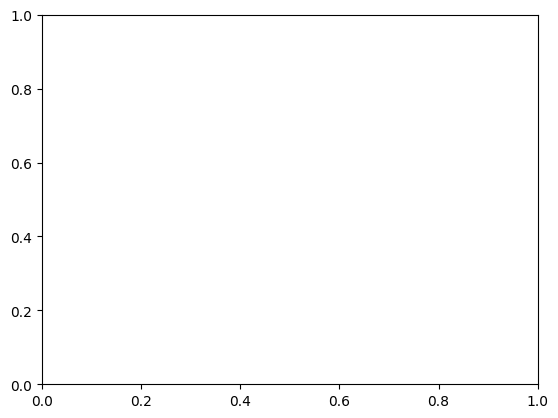

In [61]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, 'o', label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()